In [1]:
import numpy as np

import scipy as sp
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import batman
import emcee
import corner

from datetime import datetime
startTime1=datetime.now()

${\LARGE{\textbf{----READ IN DATA FILES----}}}
\\ \hspace{1cm} \textrm{currently reads in from ermay_ext files generated with the MOPSS pipeline.}
\\ \hspace{1cm} \textrm{can easily be modified to read in any data array.}$

In [2]:
path='/Volumes/ermay_ext/Magellan/ut20160811/SaveData_Wasp52/'
data=np.load(path+'LCwhite.npz')['data']
yerr=np.load(path+'LCwhite.npz')['err_t']

time=np.load(path+'Obs_times.npz')['times']

import sys
sys.path.insert(0,path) 
from SystemCons import *

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2813: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


<Container object of 3 artists>

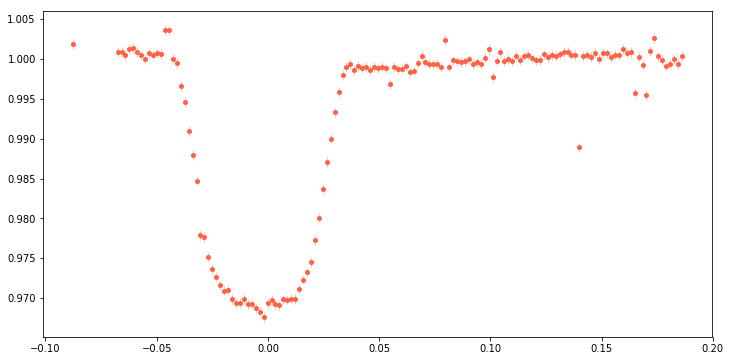

In [3]:
plt.figure(figsize=(12,6))

plt.plot(time,data,'.',markersize=8,color='tomato')
plt.errorbar(time,data,yerr=yerr*10,capsize=0,fmt=None,linewidth=0.5,color='tomato',alpha=0.8)

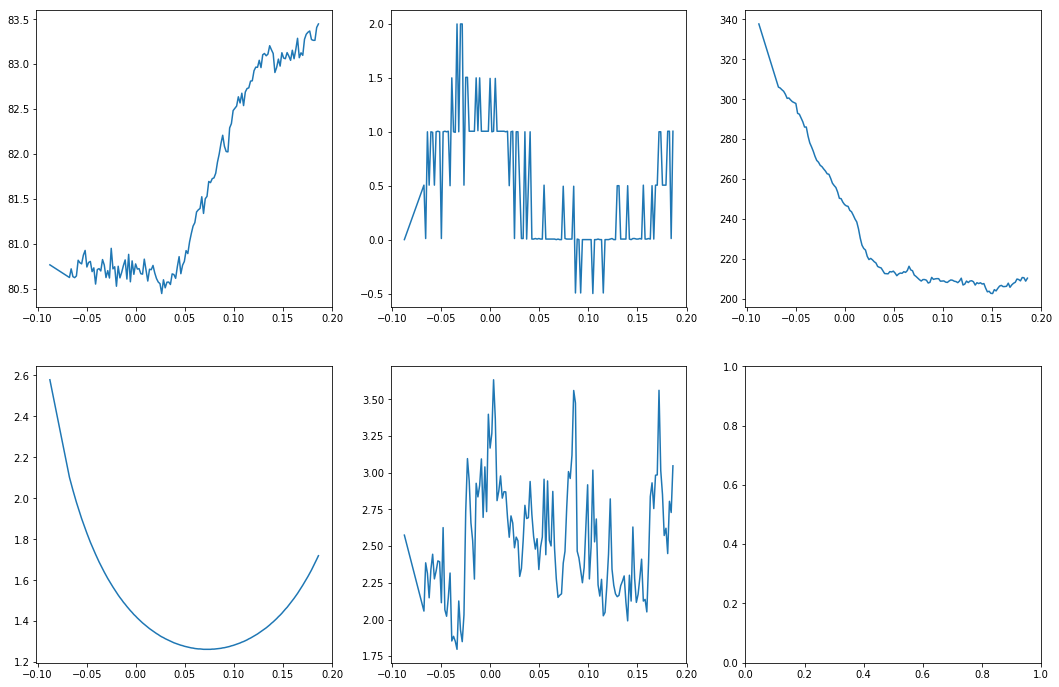

In [4]:
npar=np.load(path+'NoiseModel_Inputs_200.npz')

x_shift=npar['white_x']
y_shift=npar['yshift']
bg_cnts=npar['white_bg']

Z=(np.load(path+'HeaderData.npz')['airmass'])
fwhm=(np.load(path+'FlattenedSpectra.npz')['fwhm_ar'])[0,:]

NOISEP=np.vstack((x_shift,y_shift,bg_cnts,Z,fwhm))

fig,ax=plt.subplots(2,3,figsize=(18,12))

ax[0,0].plot(time,x_shift)
ax[0,1].plot(time,y_shift)
ax[0,2].plot(time,bg_cnts)
ax[1,0].plot(time,Z)
ax[1,1].plot(time,fwhm)
plt.show()

In [5]:
############################################################
def LC_model(t,t0,per,rp,inc,ecc,w,u0,u1):#,x0,x1,x2,x3):
    params=batman.TransitParams()
    params.t0=t0
    params.per=per
    params.rp=rp
    Ms_s=np.random.normal(loc=Ms,scale=Ms_e)
    Rs_s=np.random.normal(loc=Rs,scale=Rs_e)
    params.a=((((params.per*24.*60.*60.)**2.*Grav*Ms_s)/(4*np.pi**2.))**(1./3.))/Rs_s
    params.inc=inc
    params.ecc=ecc
    params.w=w
    params.u=(u0,u1)
    params.limb_dark='quadratic'

    model=batman.TransitModel(params,t)
    lc=model.light_curve(params)  
    
    #baseline=x0+t*(x1)+t*(x2*x2)+t*(x3*x3*x3)
    
    return lc#*baseline

############################################################
def Kern_Noise(xi,eta,sig,npm,npm2=None):
    # function defines the kernel with multiple inputs
    
    # K = number of inputs
    # A = number of exposures
    
    # n is the input matrix of parameters. should have dimensions [K,A]
    # xi is the maximum covariance hyperparameter
    # eta is an array of length K, the inverse scale parameters
    # sig is the white noise std deviation (sig^2 variance)
    
    K=npm.shape[0]
    A=npm.shape[1]
    
    COVa=np.empty([A,A])*np.nan
    
    if npm2 is None:
        for n in range(0,A):
            for m in range(0,A):
                summ=np.exp(-1.0*np.sum(eta*(npm[:,n]-npm[:,m])**2.))
                COVa[n,m]=xi*summ+1.0*sig**2.
    else:
        for n in range(0,A):
            for m in range(0,A):
                summ=np.exp(-1.0*np.sum(eta*(npm[:,n]-npm2[:,m])**2.))
                COVa[n,m]=xi*summ+1.0*sig**2.
    
    return np.copy(COVa)

############################################################
def ln_likelihood(r,K):
    try:
        val=-0.5 * (np.dot(r, np.linalg.solve(K, r)) + np.linalg.slogdet(K)[1])
    except np.linalg.LinAlgError as err:
        val=-np.inf
    return val
        

############################################################
def loggaus(mean,sig,param):
    return -np.log(np.sqrt(2*np.pi*sig**2.))-((param-mean)**2.)/(2*sig**2.)

############################################################
def lnprior(p):
    t0_f,per_f,rp_f,inc_f,u0_f,u1_f=p[:len(start)]  # ignores the cov matrix paramters
    if t0_f>t0dn and t0_f<t0up and rp_f>rpdn and rp_f<rpup and np.abs(u1_f-u1)<0.1 and np.abs((u1_f-u1)-(u0_f-u0))<0.05:
        return loggaus(per,per_e,per_f)+loggaus(inc,inc_e,inc_f)
    else:
        return -np.inf

############################################################
def lnprob(p,t,flux,err):
    # CALCULATE PRIOR #
    prior=lnprior(p)
    if not np.isfinite(prior):
        return -np.inf
    
    t0_f,per_f,rp_f,inc_f,u0_f,u1_f,eta0_f,eta1_f,eta2_f,eta3_f,eta4_f,xi_f,sig_f=p
    # CALCULATE MEAN MODEL #
    mean=LC_model(t,t0_f,per_f,rp_f,inc_f,ecc,w,u0_f,u1_f)#:,x0_f,x1_f,x2_f,x3_f)
    ress=flux-mean
    
    # CALCULATE COV MATRIX #
    eta_f=np.array([eta0_f,eta1_f,eta2_f,eta3_f,eta4_f])
    COV_f=Kern_Noise(xi_f,eta_f,sig_f,NOISEP)
    COV_f[np.diag_indices_from(COV_f)]+=err**2.
    
    # CALCULATE LOG_LIKELIHOOD #
    loglike=ln_likelihood(ress,COV_f)
    
    # CALCULATE POSTERIOR #
    post=prior+loglike
    
    if not np.isfinite(post):
        return -np.inf
    else:
        return post

############################################################
def Gaus_Samp(mu, sig, N):
    # function will generate N samples from a gaussian distribution 
    # if A is the # of dimensions for the gaussian..
    # mu = mean,  has length=A
    # sig = covariance matrix,  has size=AxA
    # N is the number of samples to draw
    
    A=mu.shape[0]              #dimensions of the gaussian
    samp=np.empty([N,A])*np.nan  #array to store samples (N samples, each with dim points)
    
    for i in range(0,N):
        samp[i,:]=np.random.multivariate_normal(mean=mu,cov=sig)
        
    return np.copy(samp)

${\LARGE{\textbf{----SET UP MCMC----}}}$

In [6]:
nwalkers=100
nburnin=100
nsteps=1500

wave=[3640,4450,5510,6580,8060,12200]#,16300,21900]                                                                                             
q0_func=interp1d(wave,q0)
q1_func=interp1d(wave,q1)

u0=q0_func(6000)
u1=q1_func(6000)

x0=0.
x1=0.
x2=0.
x3=0.

start=np.array([t0,per,rp,inc,u0,u1])

eta0=0.
eta1=0.
eta2=0.
eta3=0.
eta4=0.
xi0=0.
sig0=0.

g0=np.append(start,np.array([eta0,eta1,eta2,eta3,eta4,xi0,sig0]))
ndim=len(g0)

t0_arr=np.linspace(t0dn,t0up,10**6.)
per_arr=np.linspace(per-5*per_e,per+5*per_e,10**6.)
rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
inc_arr=np.linspace(inc-5*inc_e,inc+5*inc_e,10**6.)
u0_arr=np.linspace(u0-0.2,u0+0.2,10**6.)
u1_arr=np.linspace(u1-0.2,u1+0.2,10**6.) 

oinarr=np.linspace(-10,10,10**6.)

pos0=np.empty([nwalkers,ndim])
for i in range(nwalkers):
    pos0[i,:]=np.array([np.random.choice(t0_arr),np.random.choice(per_arr),np.random.choice(rp_arr),
                        np.random.choice(inc_arr),np.random.choice(u0_arr),np.random.choice(u1_arr),
                       np.random.choice(oinarr),np.random.choice(oinarr),np.random.choice(oinarr),
                       np.random.choice(oinarr),np.random.choice(oinarr),np.random.choice(oinarr),
                        np.random.choice(oinarr)])

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an i

${\LARGE{\textbf{----RUN MCMC----}}}$

In [7]:
sampler=emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2.0, args=(time,data,yerr))

print '     -->> Running Burn-in...'
time1=datetime.now()
p0,____,_____=sampler.run_mcmc(pos0,nburnin)
time2=datetime.now()
print '           Time to Run: ', time2-time1
sampler.reset()

print '     -->> Running Chain...'
for i, result in enumerate(sampler.sample(p0,iterations=nsteps)):
    if (i+1)%(nsteps/10) ==0:
        print 100.*(float(i+1) / nsteps),'          ', datetime.now()
        
print '     -->> Mean Acceptance Fraction: ', np.mean(sampler.acceptance_fraction)

samples=sampler.chain[:,:,:].reshape((-1,pos0.shape[1]))

     -->> Running Burn-in...


/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in double_scalars
/usr/local/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/usr/local/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


           Time to Run:  0:15:59.912152
     -->> Running Chain...


/usr/local/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1817: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


10.0            2018-08-07 15:46:54.462711
20.0            2018-08-07 16:21:01.085429
30.0            2018-08-07 16:55:16.343582
40.0            2018-08-07 17:30:34.396513
50.0            2018-08-07 18:05:45.849203
60.0            2018-08-07 18:41:51.404480
70.0            2018-08-07 19:17:36.286223
80.0            2018-08-07 19:54:54.671930
90.0            2018-08-07 20:31:46.771063
100.0            2018-08-07 21:08:05.540397
     -->> Mean Acceptance Fraction:  0.009046666666666666


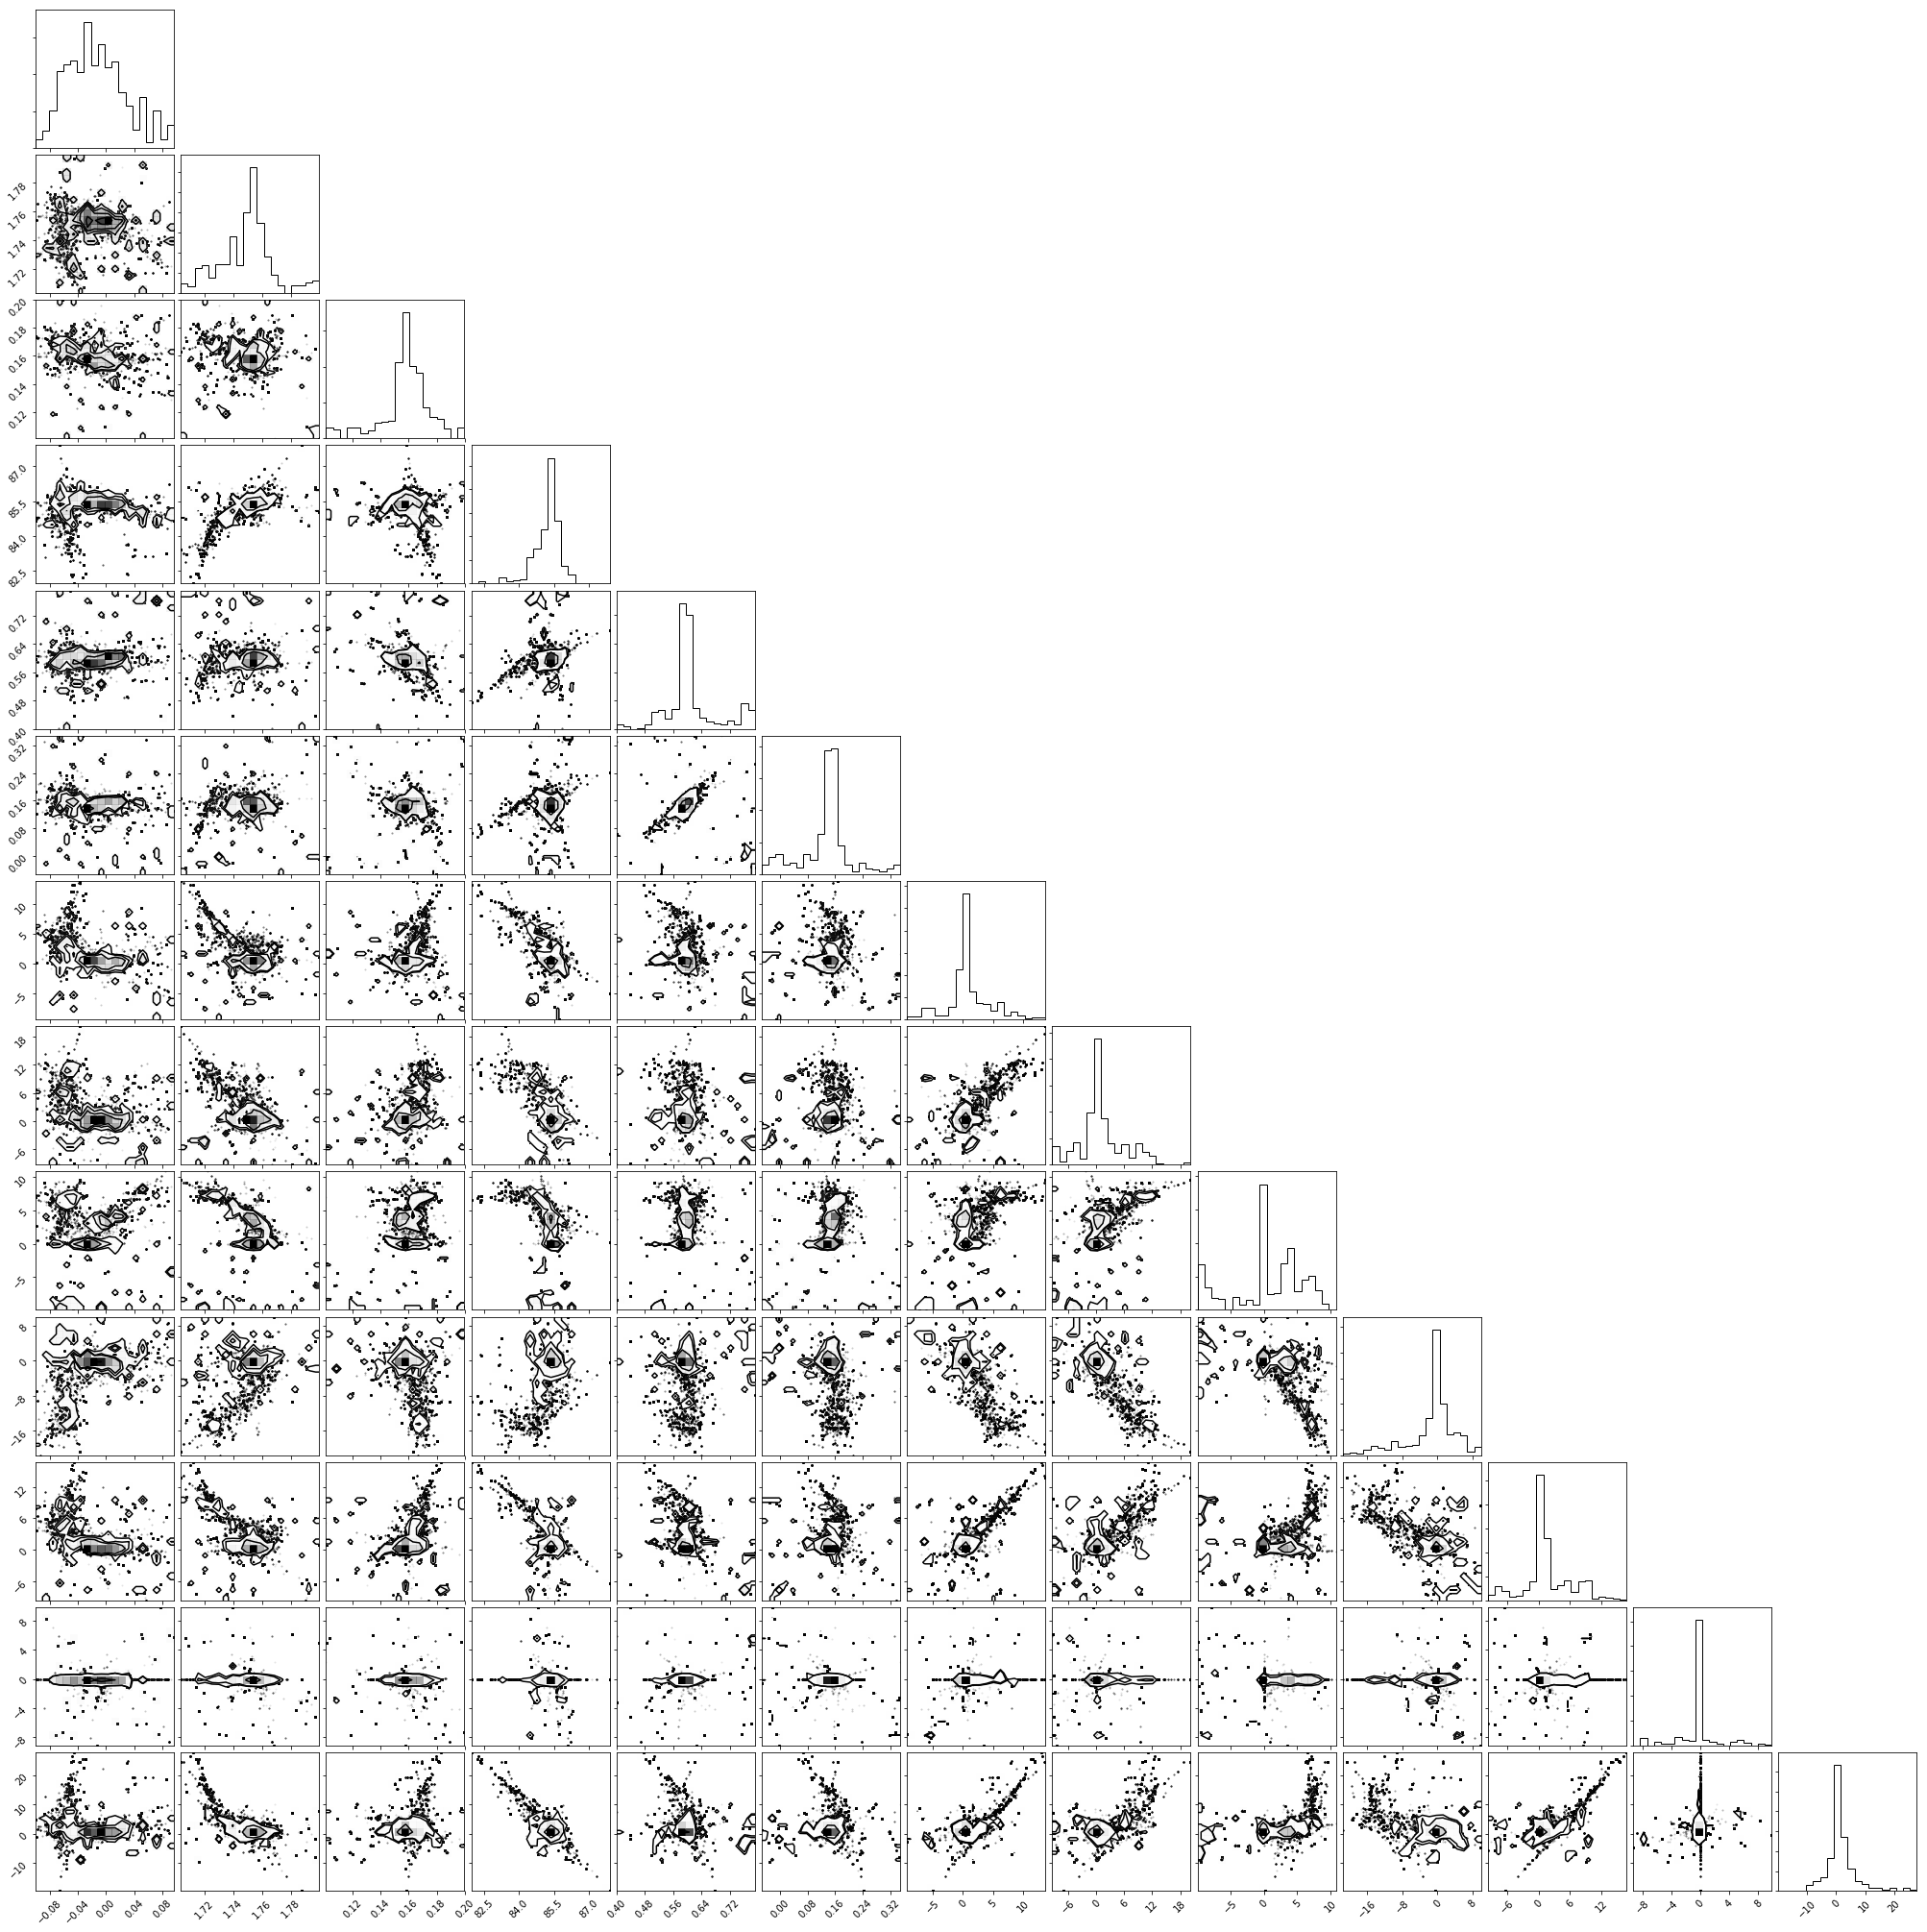

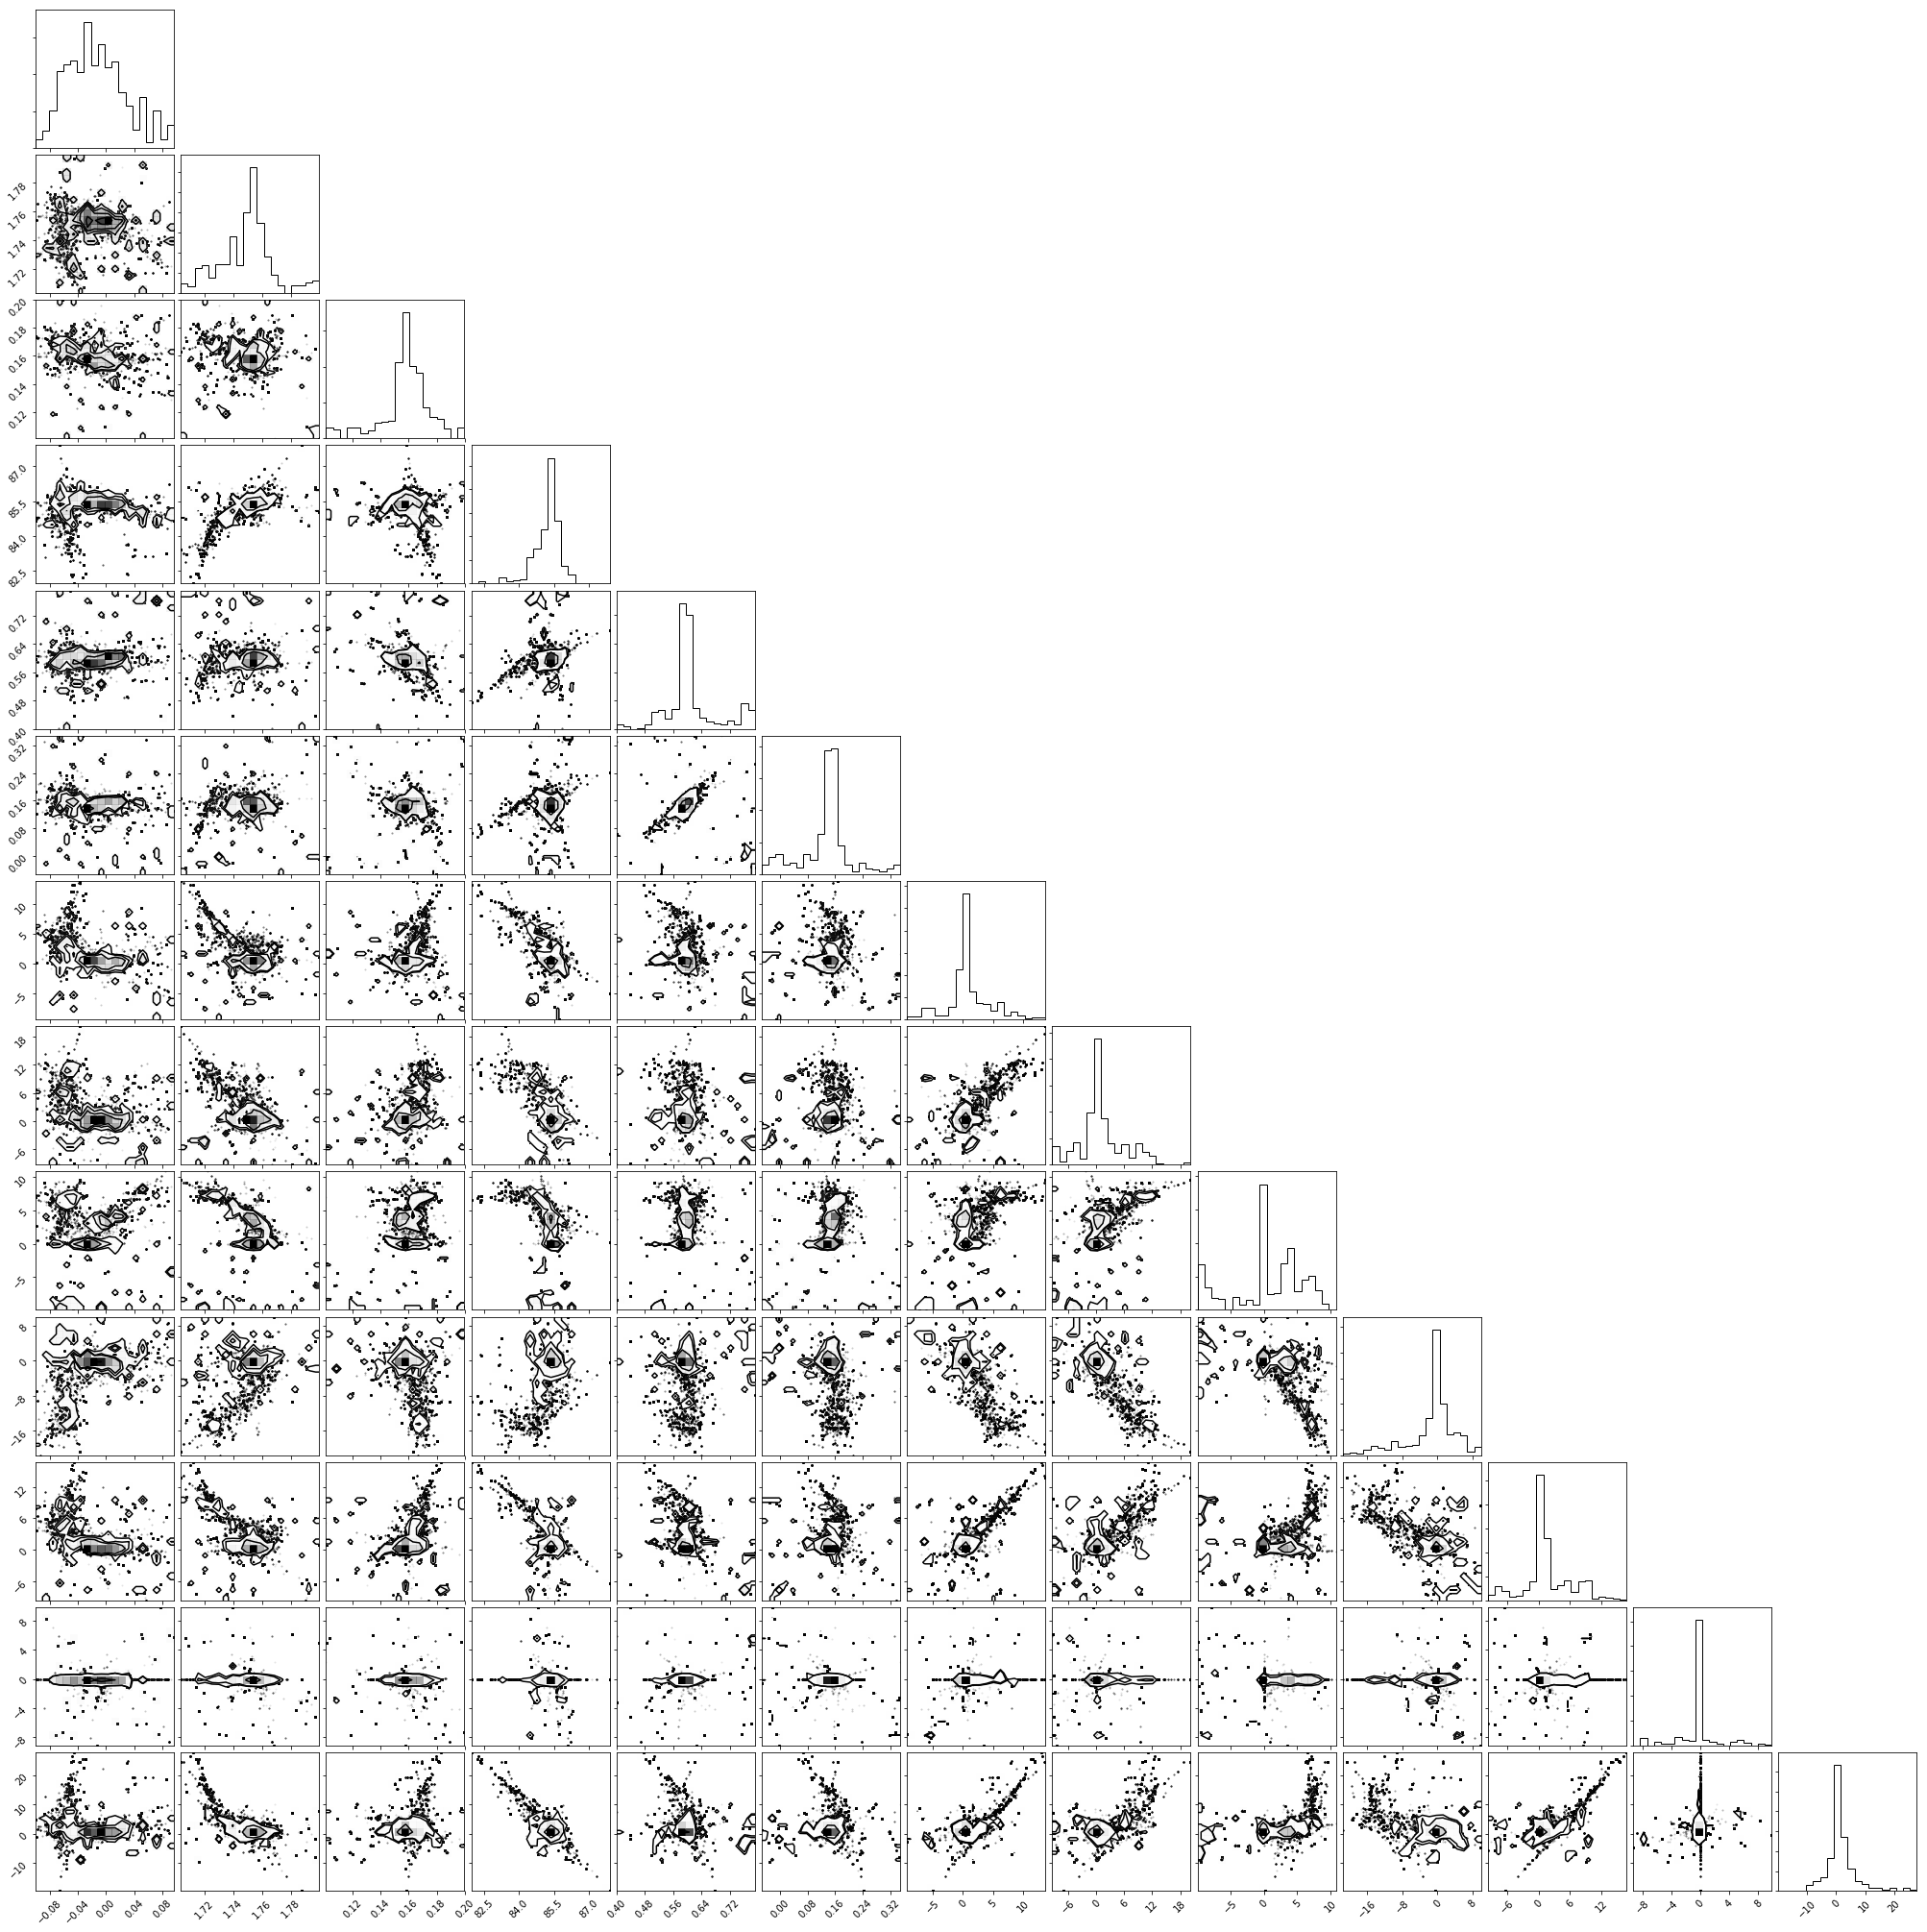

In [8]:
corner.corner(samples)

-0.01485659692436564 1.7508546724995304 0.15833785833785835 85.33462125103809 0.0 0.0 0.5962414494585166 0.14194020195151522


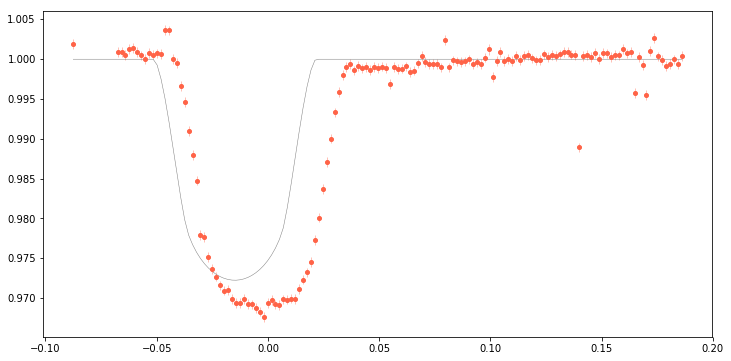

In [10]:
t0o,pero,rpo,inco,u0o,u1o,e0o,e1o,e2o,e3o,e4o,xio,sigo=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84], axis=0)))
t0,per,rp,inc,u0,u1=t0o[0],pero[0],rpo[0],inco[0],u0o[0],u1o[0]

print t0,per,rp,inc,ecc,w,u0,u1

mean=LC_model(time,t0,per,rp,inc,ecc,w,u0,u1)

plt.figure(101,figsize=(12,6))
plt.plot(time,mean,'-',linewidth=0.5,color='grey')
plt.plot(time,data,'.',markersize=8,color='tomato')
plt.errorbar(time,data,yerr=yerr*10,capsize=0,fmt=None,linewidth=0.5,color='tomato',alpha=0.8)
plt.show()

In [14]:
e0,e1,e2,e3,e4,xi,sig=e0o[0],e1o[0],e2o[0],e3o[0],e4o[0],xio[0],sigo[0]

eta=np.array([e0,e1,e2,e3,e4])

print eta, xi, sig

fin_COV=Kern_Noise(xi,eta,sig,NOISEP)

r=data-mean
mean_func=mean+np.dot((fin_COV.T),np.linalg.solve(fin_COV,r))

fin_sig=np.sqrt(np.diag(fin_COV))

print fin_sig

[ 0.18641631  0.41239041  0.51500029 -0.09053457  0.72094764] -9.191565401230548e-05 0.8894569293867085
[0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526 0.88940526
 0.88940526 0.88940526 0.

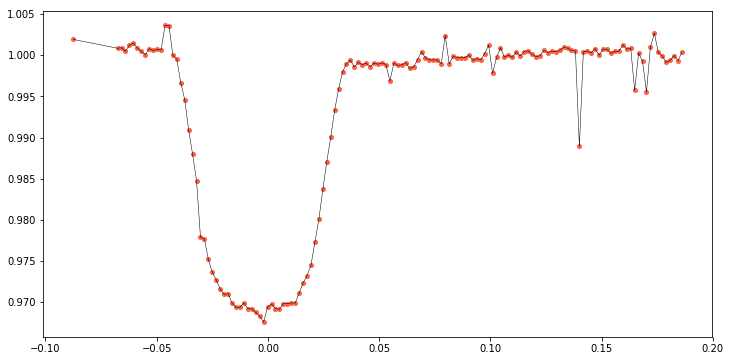

In [17]:
plt.figure(figsize=(12,6))
plt.plot(time,data,'.',color='tomato',markersize=8)
plt.plot(time,mean_func,'-',linewidth=0.5,color='black')
#plt.fill_between(time,mean_func-2.0*fin_sig,mean_func+2.0*fin_sig,color='grey',alpha=0.6)

${\LARGE{\textbf{----2D GAUSSIAN EXAMPLE----}}}$

(10, 2)


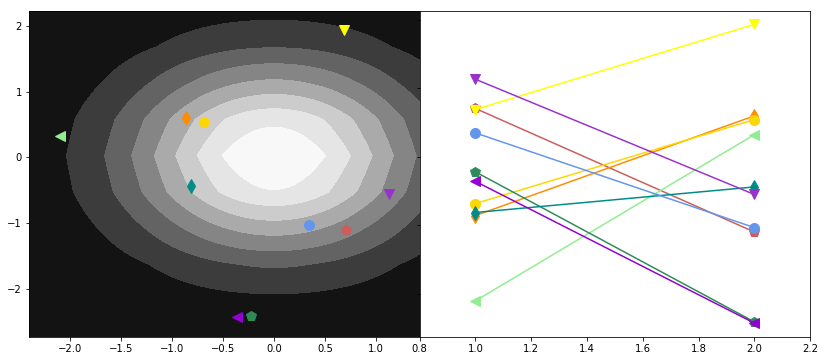

In [60]:
mu=np.array([0.0,0.0])
sig=np.array([[1,0],[0,1]])

colors = ['indianred','darkorange','gold','yellow','lightgreen',
          'seagreen','darkcyan','cornflowerblue','darkorchid','darkviolet']
markers = ['p','d','o','v','<','p','d','o','v','<']

N=10

test=Gaus_Samp(mu,sig,N)
print test.shape

fig,ax=plt.subplots(1,2,figsize=(14,6))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

x=test[:,0]
y=test[:,1]
X, Y = np.meshgrid(np.linspace(np.nanmin(x)-0.3,np.nanmax(x)+0.3,100), 
                       np.linspace(np.nanmin(y)-0.3,np.nanmax(y)+0.3,N))
rv = multivariate_normal(mu, sig)
Z=rv.pdf(np.dstack((X,Y)))

ax[0].contourf(X,Y,Z,cmap=matplotlib.cm.Greys_r)

for i in range(0,N):
    ax[0].plot(test[i,0],test[i,1],'o',color=colors[i],marker=markers[i],ms=10)

A=test.shape[1]
x=np.array(range(1,A+1))
for i in range(0,N):
    ax[1].plot(x,test[i,:],'-o',marker=markers[i],color=colors[i],ms=10)
        
    ax[1].set_xlim(0.8,x[-1]+0.2)
    ax[1].set_ylim(np.nanmin(test)-0.2,np.nanmax(test)+0.2)
    ax[1].set_yticklabels([],[])

${\LARGE{\textbf{---- >2D GAUSSIAN----}}}$


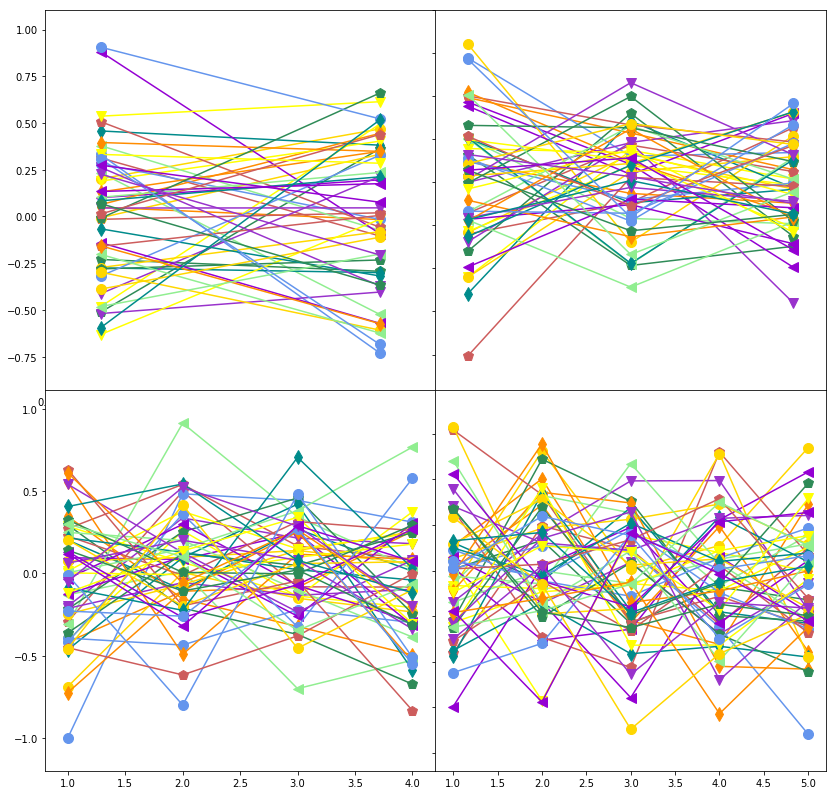

In [68]:
colors = ['indianred','darkorange','gold','yellow','lightgreen',
          'seagreen','darkcyan','cornflowerblue','darkorchid','darkviolet']
markers = ['p','d','o','v','<','p','d','o','v','<']

N=50

mu2=np.array([0.0,0.0])
sig2=np.array([[1,0],[0,1]])*0.1

mu3=np.linspace(0,1,3)*0.0
sig3=np.identity(3)*0.1

mu4=np.linspace(0,1,4)*0.0
sig4=np.identity(4)*0.1

mu5=np.linspace(0,1,5)*0.0
sig5=np.identity(5)*0.1

fig,ax=plt.subplots(2,2,figsize=(14,14))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

# 2 D
test=Gaus_Samp(mu2,sig2,N)
A=test.shape[1]
x=np.array(range(1,A+1))
for i in range(0,N):
    ax[0,0].plot(x,test[i,:],'-o',marker=markers[i%10],color=colors[i%10],ms=10)
        
    ax[0,0].set_xlim(0.8,x[-1]+0.2)
    ax[0,0].set_ylim(np.nanmin(test)-0.2,np.nanmax(test)+0.2)

# 3 D
test=Gaus_Samp(mu3,sig3,N)
A=test.shape[1]
x=np.array(range(1,A+1))
for i in range(0,N):
    ax[0,1].plot(x,test[i,:],'-o',marker=markers[i%10],color=colors[i%10],ms=10)
        
    ax[0,1].set_xlim(0.8,x[-1]+0.2)
    ax[0,1].set_ylim(np.nanmin(test)-0.2,np.nanmax(test)+0.2)
    ax[0,1].set_yticklabels([],[])
    
# 4 D
test=Gaus_Samp(mu4,sig4,N)
A=test.shape[1]
x=np.array(range(1,A+1))
for i in range(0,N):
    ax[1,0].plot(x,test[i,:],'-o',marker=markers[i%10],color=colors[i%10],ms=10)
        
    ax[1,0].set_xlim(0.8,x[-1]+0.2)
    ax[1,0].set_ylim(np.nanmin(test)-0.2,np.nanmax(test)+0.2)
    
# 5 D
test=Gaus_Samp(mu5,sig5,N)
A=test.shape[1]
x=np.array(range(1,A+1))
for i in range(0,N):
    ax[1,1].plot(x,test[i,:],'-o',marker=markers[i%10],color=colors[i%10],ms=10)
        
    ax[1,1].set_xlim(0.8,x[-1]+0.2)
    ax[1,1].set_ylim(np.nanmin(test)-0.2,np.nanmax(test)+0.2)
    ax[1,1].set_yticklabels([],[])
